In [1]:
%pylab inline
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import numpy as np

chunk = 'chunk22'

topdir = '/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/subset/'
fn = 'eBOSS_ELG_full_ALL_v4.dat_cutted_really_masked_chunk22_psfdepth_match.fits'
fn_obiwan = 'obiwan_200per_0125_really_masked_chunk22_psfdepth_match.fits'
fn_sim = 'sim_200per_0125.fits'
DAT = fits.getdata(topdir+fn)
obiwan = fits.getdata(topdir+fn_obiwan)
sim = fits.getdata(topdir+fn_sim)
fn_sim_m = 'sim_w_psfdepthcut_cutted.fits'
sim_m = fits.getdata(topdir+fn_sim_m)

'''
useful output are:
** DAT: real elgs
** obiwan: obiwan output
** sim_m: uniform randoms
'''

Populating the interactive namespace from numpy and matplotlib


'\nuseful output are:\n** DAT: real elgs\n** obiwan: obiwan output\n** sim_m: uniform randoms\n'

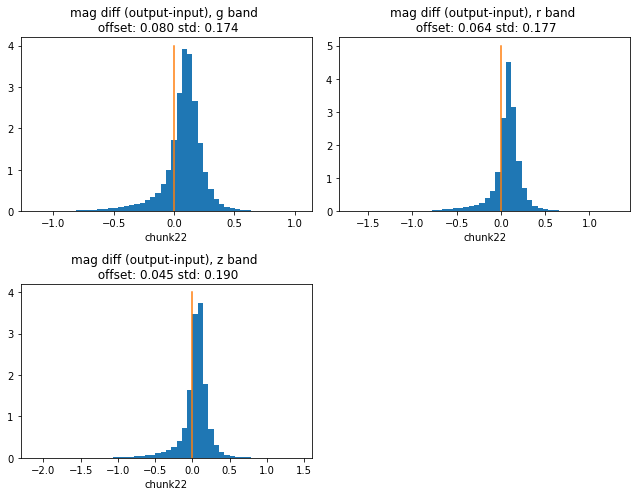

In [2]:
#magnitude offset
def MAG(mag, data = obiwan):
    g     = 22.5 - 2.5 * np.log10(data['flux_g'] / data['mw_transmission_g'])
    r_mag = 22.5 - 2.5 * np.log10(data['flux_r'] / data['mw_transmission_r'])
    z_mag = 22.5 - 2.5 * np.log10(data['flux_z'] / data['mw_transmission_z'])
    if mag == 'g':
        return g
    if mag == 'r':
        return r_mag
    if mag == 'z':
        return z_mag
def offset(mag, plot_index, data = obiwan):
    plt.subplot(2,2,plot_index)
    mag_diff = MAG(mag) - data[mag]
    n, bins, patches = plt.hist(mag_diff,bins = 50,normed = True)
    y = np.arange(n.max()+1)
    x = np.zeros(len(y))
    plt.plot(x,y)
    plt.xlabel(chunk)
    plt.title('mag diff (output-input), %s band \n offset: %.3f std: %.3f' % (mag, mag_diff.mean(), mag_diff.std()))
plt.figure(figsize = (9,7))
offset('g',1)
offset('r',2)
offset('z',3)
plt.tight_layout()

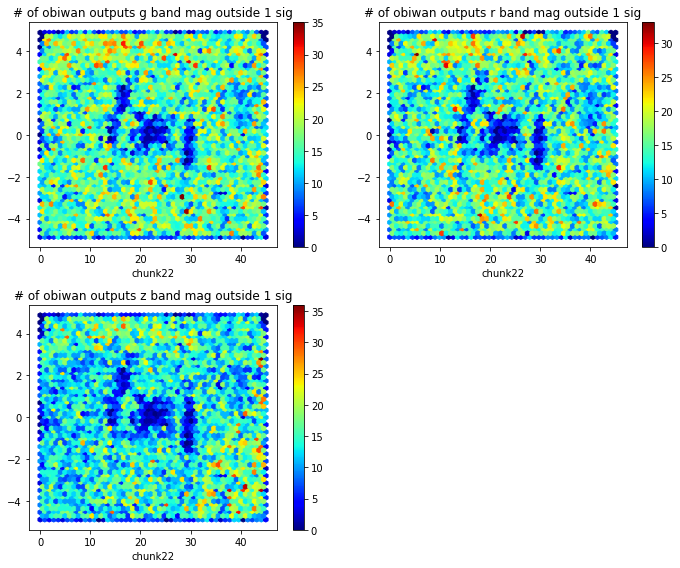

In [11]:
def mag_dist(mag,plt_idx, data = obiwan):
    mag_diff = MAG(mag) - obiwan[mag]
    sup = mag_diff.mean() + mag_diff.std()
    inf = mag_diff.mean() - mag_diff.std()
    sel = (mag_diff<sup)&(mag_diff>inf)
    dat_sel = data[sel==False] 
    plt.subplot(2,2,plt_idx)
    plt.hexbin(dat_sel['ra'],dat_sel['dec'],gridsize = 50, cmap = 'jet')
    plt.colorbar()
    plt.xlabel(chunk)
    plt.title('# of obiwan outputs '+mag+' band mag outside 1 sig')    

plt.figure(figsize = (10,8))
mag_dist('g',1)
mag_dist('r',2)
mag_dist('z',3)
plt.tight_layout()

KeyError: "Key 'g' does not exist."

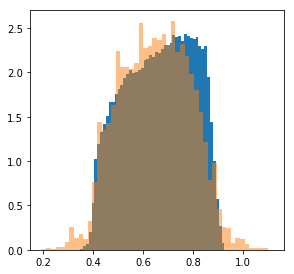

In [12]:
def mag_alg_hist(TYPE, plt_idx, data = obiwan):
    plt.subplot(3,2,plt_idx)
    bin_arg = dict(bins = 50, stacked = False, normed=True)
    if TYPE == 'g-r':
        #g-r hist input,output (to ELG cut)
        plt.hist(MAG('g')-MAG('r'),label = 'output', **bin_arg)
        plt.hist(data['g'] - data['r'], label = 'input, after ELG cut',alpha = 0.5, **bin_arg)
        plt.hist(sim_m['g'] - sim_m['r'], label = 'input, before ELG cut', alpha=0.5, **bin_arg)
        plt.legend()
        plt.title('g-r mag ' + chunk)
    elif TYPE == 'r-z':
        #r-z hist input,output (to ELG cut)
        plt.hist(MAG('r')-MAG('z'),label = 'output', **bin_arg)
        plt.hist(data['r'] - data['z'], label = 'input, after ELG cut',alpha=0.5, **bin_arg)
        plt.hist(sim_m['r'] - sim_m['z'], label = 'input, before ELG cut', alpha=0.5, **bin_arg)
        plt.legend()
        plt.title('r-z mag, chunk22') 
    else:
        assert(TYPE in ['g','r','z'])
        plt.hist(MAG(TYPE),label = 'output', **bin_arg)
        plt.hist(obiwan[TYPE], label = 'input, after ELG cut',alpha=0.5, **bin_arg)
        plt.hist(sim[TYPE], label = 'input, before ELG cut',alpha=0.5, **bin_arg)
        plt.legend()
        plt.title(TYPE+' mag '+chunk)
plt.figure(figsize = (10,15))
mag_alg_hist('g-r',1)
mag_alg_hist('r-z',2)
mag_alg_hist('g',3)
mag_alg_hist('r',4)
mag_alg_hist('z',5)

In [236]:
def compare_obiwan(res = 128, obiwan = obiwan):
    import healpy as hp
    #mean <mag-mag_true> plot g,r,z
    pixs = hp.ang2pix(128,obiwan['ra'],obiwan['dec'],nest = True, lonlat = True)
    pixs2 = hp.ang2pix(128,sim_m['ra'], sim_m['dec'], nest = True, lonlat = True)
    pixs3 = hp.ang2pix(128,DAT['ra'],DAT['dec'],nest = True, lonlat = True)
    N = 12*128**2
    hist_n = np.zeros(N)
    hist_mag_diff_g = np.zeros(N)
    hist_mag_diff_r = np.zeros(N)
    hist_mag_diff_z = np.zeros(N)
    mag_g = MAG('g',data = obiwan)
    mag_r =  MAG('r', data = obiwan)
    mag_z = MAG('z', data = obiwan)
    for i in range(len(pixs)):
        n = pixs[i]
        mag_diff_g = mag_g[i] - obiwan['g'][i]
        mag_diff_r = mag_r[i] - obiwan['r'][i]
        mag_diff_z = mag_z[i] - obiwan['z'][i]
        hist_mag_diff_g[n]+=mag_diff_g
        hist_mag_diff_r[n]+=mag_diff_r
        hist_mag_diff_z[n]+=mag_diff_z
        hist_n[n]+=1
    hist2 = np.zeros(N)
    for i in range(len(pixs2)):
        n = pixs2[i]
        hist2[n]+=1
    hist3 = np.zeros(N)
    for i in range(len(pixs3)):
        n = pixs3[i]
        hist3[n]+=1

    
    N = 12*res**2
    ra,dec = hp.pix2ang(128,np.arange(N), nest = True,lonlat = True)
    col1 = fits.Column(name = 'ra', array = ra, format = 'D')
    col2 = fits.Column(name = 'dec', array = dec, format = 'D')
    # # of obiwans in each pixel
    col3 = fits.Column(name = 'num_obiwan', array = hist_n, format = 'D')
    col4 = fits.Column(name = 'hist_mag_diff_g', array = hist_mag_diff_g, format = 'D')
    col5 = fits.Column(name = 'hist_mag_diff_r', array = hist_mag_diff_r, format = 'D')
    col6 = fits.Column(name = 'hist_mag_diff_z', array = hist_mag_diff_z, format = 'D')
    # # of uniform randoms in each pixel
    col7 = fits.Column(name = 'num_uniform', array = hist2, format = 'D')
    # # of real elgs in each pixel
    col8 = fits.Column(name = 'num_elgs', array = hist3, format = 'D')
    
    #bad pixels
    g = obiwan['g']
    rz = obiwan['r'] - obiwan['z']
    gr = obiwan['g'] - obiwan['r']
    color_sgc = (g>21.825)&(g<22.825)&(-0.068*rz+0.457<gr)&(gr< 0.112*rz+0.773) &(0.218*gr+0.571<rz)&(rz<-0.555*gr+1.901)
    dat_bad = obiwan[color_sgc==False]
    pixs_bad = hp.ang2pix(128,dat_bad['ra'],dat_bad['dec'],nest = True, lonlat = True)
    hist_bad = np.zeros(N)
    for i in range(len(pixs_bad)):
        n = pixs_bad[i]
        hist_bad[n]+=1
    col9 = fits.Column(name = 'num_bad', array = hist_bad, format = 'D')
    dat = fits.BinTableHDU.from_columns([col1,col2,col3,col4,col5,col6,col7,col8,col9]).data
    uni = dat['num_uniform']
    sel = (uni>0)
    return dat[sel]
#obiwan rearanged in healpix format
compact_obiwan = compare_obiwan()
'''
output update:
** DAT: real elgs
** obiwan: obiwan output
** sim_m: uniform randoms
** compact_obiwan
'''

'\noutput update:\n** DAT: real elgs\n** obiwan: obiwan output\n** sim_m: uniform randoms\n** compact_obiwan\n'

In [237]:
compact_obiwan.columns

ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'num_obiwan'; format = 'D'
    name = 'hist_mag_diff_g'; format = 'D'
    name = 'hist_mag_diff_r'; format = 'D'
    name = 'hist_mag_diff_z'; format = 'D'
    name = 'num_uniform'; format = 'D'
    name = 'num_elgs'; format = 'D'
    name = 'num_bad'; format = 'D'
)

'\noutput update:\n** DAT: real elgs\n** obiwan: obiwan output\n** sim_m: uniform randoms\n** compact_obiwan -- hp outputs\n** hp_obiwan -- hp outputs w/ cut to > 350 uniforms per pix\n'

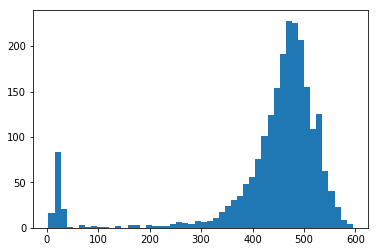

In [238]:
pt = plt.hist(compact_obiwan['num_uniform'],bins=50)
#have a cut @ 350
def cut_uni(cut_set = 350):
    uni = compact_obiwan['num_uniform']
    sel = (uni>350)
    hp_obiwan = compact_obiwan[sel]
    return hp_obiwan
hp_obiwan = cut_uni()
'''
output update:
** DAT: real elgs
** obiwan: obiwan output
** sim_m: uniform randoms
** compact_obiwan -- hp outputs
** hp_obiwan -- hp outputs w/ cut to > 350 uniforms per pix
'''

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


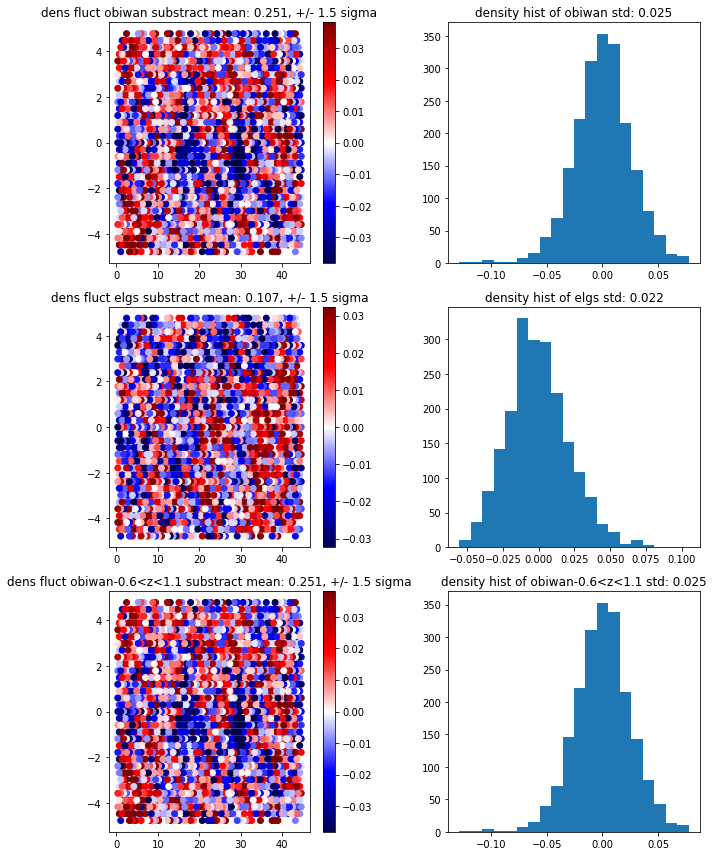

In [239]:
#number density fluctuation
def nb_dens_fluc(TYPE,plt_idx,data = hp_obiwan):
    plt.subplot(3,2,plt_idx)
    assert(TYPE in ['obiwan','elgs','obiwan-0.6<z<1.1'])
    if TYPE == 'obiwan' or TYPE == 'obiwan-0.6<z<1.1':
        color = data['num_obiwan']/data['num_uniform']
    else:
        color = data['num_elgs']/data['num_uniform']
    mean = color.mean()
    std = color.std()
    plt.scatter(data['ra'],data['dec'],c=color-mean,cmap = 'seismic',vmin = -std*1.5,vmax = 1.5*std)
    plt.colorbar()
    plt.title('dens fluct '+ TYPE +' substract mean: %.3f, +/- 1.5 sigma' % mean)
    plt.subplot(3,2,plt_idx+1)
    plt.hist(color-mean,bins = 20)
    std = (color-mean).std()
    plt.title('density hist of '+ TYPE +' std: %.3f' % std)
plt.figure(figsize = (10,12))
nb_dens_fluc('obiwan',1)
nb_dens_fluc('elgs',3)



#number density fluctuation for obiwan at 0.6<z<1.1
def nb_dens_fluc_w_redshift_cut(plt_idx = 5, z_min = 0.6,zmax = 1.1):
    redshift = obiwan['nn_redshift']
    obiwan_sel = (redshift<1.1)&(redshift>0.6)
    obiwan_rf_cut = obiwan[obiwan_sel]
    obiwan_rf_cutted = compare_obiwan(res = 128, obiwan = obiwan_rf_cut)
    uni = obiwan_rf_cutted['num_uniform']
    sel = (uni>350)
    hp_obiwan_cutted = compact_obiwan[sel]
    plt.subplot(3,2,plt_idx)
    nb_dens_fluc('obiwan-0.6<z<1.1',plt_idx,data = hp_obiwan_cutted)
    
nb_dens_fluc_w_redshift_cut()
plt.tight_layout()

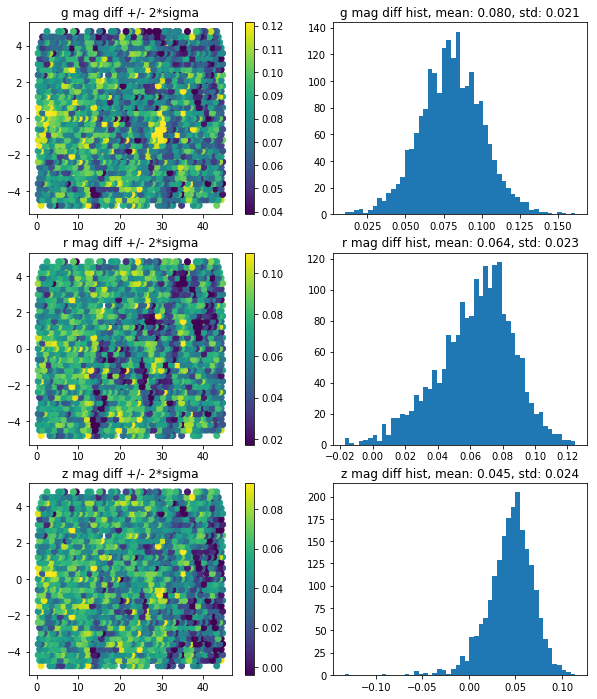

In [240]:
def plt_gen(Color, plt_idx, dat = hp_obiwan):
    plt.subplot(3,2,plt_idx)
    color = dat['hist_mag_diff_'+Color]/dat['num_obiwan']
    mean,std = color.mean(),color.std()
    sc = plt.scatter(hp_obiwan['ra'],hp_obiwan['dec'],c=color,vmin = mean-2*std, vmax = mean+2*std)
    plt.colorbar(sc)
    plt.title(Color+' mag diff +/- 2*sigma')
    plt.subplot(3,2,plt_idx+1)
    pt = plt.hist(color,bins = 50)
    plt.title(Color+' mag diff hist, mean: %.3f, std: %.3f' % (mean,std))

plt.figure(figsize=(10,12))    
plt_gen('g',1)
plt_gen('r',3)
plt_gen('z',5)

comparision between the hole region and the problematic reion: (ra1,ra2,dec1,dec2)=(27,33,-2,2)
mag diff for real elgs in this region is: 0.00111
mag diff for obiwan in this region is: 0.00085
mag diff for input in this region is: 0.00062
mag diff for diff in out-in change in this region is: 0.00177


'\nconclusion: sky subtraction might change the g mag a little in this region\nThis effect has a larger impact on obiwan because obiwan has fewer input outside the selection box\n'

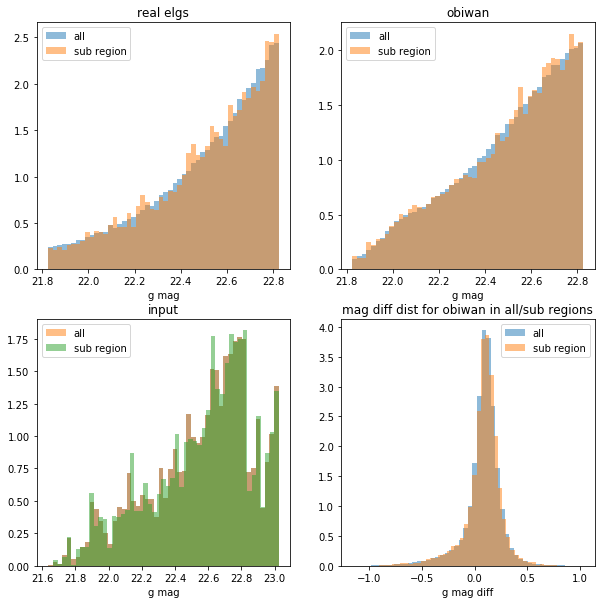

In [241]:
#why is there a region around 30,0 looking weird in g mag diff & density plot?
print('comparision between the hole region and the problematic reion: (ra1,ra2,dec1,dec2)=(27,33,-2,2)')
def sub_region_examine():
    #g mag difference in DAT for whole patch & this patch only (27,33,-2,2)
    plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    hist1 = plt.hist(DAT['g'],bins = 50,alpha = 0.5,normed = True, label = 'all')
    ra = DAT['ra']
    dec = DAT['dec']
    sel = (ra>27)&(ra<33)&(dec>-2)&(dec<2)
    DAT_sel = DAT[sel]
    hist2 = plt.hist(DAT_sel['g'],bins = 50,alpha = 0.5,normed = True, label = 'sub region')
    plt.title('real elgs')
    plt.legend()
    plt.xlabel('g mag')
    print('mag diff for real elgs in this region is: %.5f' % (DAT_sel['g'].mean()-DAT['g'].mean()))
    
    
    plt.subplot(2,2,2)
    g = MAG('g')
    plt.hist(g,bins = 50,alpha = 0.5,normed = True, label = 'all')
    ra = obiwan['ra']
    dec = obiwan['dec']
    sel = (ra>27)&(ra<33)&(dec>-2)&(dec<2)
    obiwan_sel = obiwan[sel]
    g_sel = 22.5 - 2.5 * np.log10(obiwan_sel['flux_g'] / obiwan_sel['mw_transmission_g'])
    hist = plt.hist(g_sel,bins = 50,alpha = 0.5,normed = True, label = 'sub region')
    plt.title('obiwan')
    plt.legend()
    plt.xlabel('g mag')
    print('mag diff for obiwan in this region is: %.5f' %(g_sel.mean()-g.mean()))
    
    plt.subplot(2,2,3)
    g = sim_m['g']
    plt.hist(g,bins = 50,alpha = 0.5,normed = True)
    ra = sim_m['ra']
    dec = sim_m['dec']
    sel = (ra>27)&(ra<33)&(dec>-2)&(dec<2)
    sim_m_sel = sim_m[sel]
    g_sel = sim_m_sel['g']
    plt.hist(g,bins = 50,alpha = 0.5,normed = True, label = 'all')
    plt.hist(g_sel,bins = 50,alpha = 0.5,normed = True, label = 'sub region')
    plt.title('input')
    plt.legend()
    plt.xlabel('g mag')
    print('mag diff for input in this region is: %.5f' %(g_sel.mean()-g.mean()))    
    
    plt.subplot(2,2,4)
    g_out = MAG('g')
    g_in = obiwan['g']
    g_diff = g_out-g_in
    plt.hist(g_diff,bins = 50,alpha = 0.5,normed = True, label = 'all')
    ra = obiwan['ra']
    dec = obiwan['dec']
    sel = (ra>27)&(ra<33)&(dec>-2)&(dec<2)    
    obiwan_sel = obiwan[sel]
    g_out_sel = 22.5 - 2.5 * np.log10(obiwan_sel['flux_g'] / obiwan_sel['mw_transmission_g']) 
    g_in_sel = obiwan_sel['g']
    g_diff_sel = g_out_sel - g_in_sel
    plt.hist(g_diff_sel,bins = 50,alpha = 0.5,normed = True, label = 'sub region')
    plt.title('mag diff dist for obiwan in all/sub regions')
    plt.xlabel('g mag diff')
    plt.legend()
    print('mag diff for diff in out-in change in this region is: %.5f' % (g_diff_sel.mean()-g_diff.mean()))  
sub_region_examine()

'''
conclusion: sky subtraction might change the g mag a little in this region
This effect has a larger impact on obiwan because obiwan has fewer input outside the selection box
'''

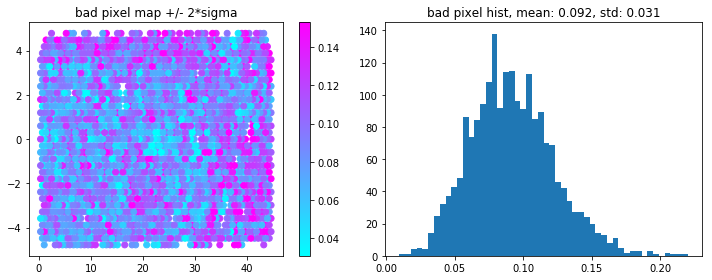

In [145]:
#bad pixel map
def bd_pix_plt_gen(dat = hp_obiwan):
    plt.subplot(1,2,1)
    color = dat['num_bad']/dat['num_obiwan']
    mean,std = color.mean(),color.std()
    sc = plt.scatter(hp_obiwan['ra'],hp_obiwan['dec'],c=color,cmap = 'cool',vmin = mean-2*std, vmax = mean+2*std)
    plt.colorbar(sc)
    plt.title('bad pixel map +/- 2*sigma')
    plt.subplot(1,2,2)
    pt = plt.hist(color,bins = 50)
    plt.title('bad pixel hist, mean: %.3f, std: %.3f' % (mean,std))
plt.figure(figsize = (10,4))
bd_pix_plt_gen()
plt.tight_layout()

In [124]:
#TODO: good elgs out

Text(0.5,0,'number of incidents')

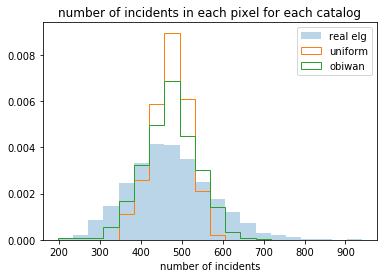

In [160]:
#n_gal/n_obi 
#find n_obi in each pixel, 
sum1 = hp_obiwan['num_uniform'].sum()
sum2 = hp_obiwan['num_elgs'].sum()
sum3 = hp_obiwan['num_obiwan'].sum()
n,bins,patches = plt.hist(hp_obiwan['num_elgs']*sum1/sum2,histtype='stepfilled',normed = True, bins=20,alpha = 0.3,label = 'real elg')
plt.hist(hp_obiwan['num_uniform'],histtype='step',normed = True, bins = bins,label = 'uniform')
plt.hist(hp_obiwan['num_obiwan']*sum1/sum3,histtype='step',normed = True, bins = bins,label = 'obiwan')
plt.legend()
plt.title('number of incidents in each pixel for each catalog')
plt.xlabel('number of incidents')

In [217]:
def sys_test(MAP, data, random,xlabel):
    coeff = 1.5
    #all in healpix format +/- 1.5 sigma
    mean,std = MAP.mean(),MAP.std()
    sysmin,sysmax = mean - coeff*std, mean + coeff*std
    
    #total bins
    nsysbin = 12
    bing = np.zeros(nsysbin)
    binr = np.zeros(nsysbin)
    
    bintg = data.sum()#total galaxies in good pixel
    bintr = random.sum()#total random in good pixel
    obing = 0#total galaxies outside bin
    obinr = 0#total randoms outside bin
    ng0 = 0#total galaxies in bad pixel
    nr0 = 0#total random in bad pixel
    sysm = float(nsysbin)/(sysmax-sysmin)
    
    for i in range(0,len(MAP)):
        sysv = MAP[i]
        bins = int((sysv-sysmin)*sysm)
        if bins >= 0 and bins < nsysbin:
            bing[bins] += data[i]
            binr[bins] += random[i]
        else:
            obing += data[i]
            obinr += random[i]   
    print('total number of randoms/objects '+str(bintr)+'/'+str(bintg))
    print('number of randoms/objects outside tested range '+str(obinr)+'/'+str(obing))
    ave = float(bintg)/float(bintr)
    print('average number of objects per random is '+ str(ave))
    
    sys_data = np.zeros(nsysbin*3).reshape(nsysbin, 3)
    for i in range(0,nsysbin):
        sysv = sysmin + 1./(2.*sysm) + i/sysm
        if binr[i] > 0:
            ns = bing[i]/binr[i]/ave
            nse = sqrt(bing[i]/(binr[i])**2./(ave)**2.+(bing[i]/ave)**2./(binr[i])**3.)
        else:
            ns = 1.
            nse = 1.
        sys_data[i][0],sys_data[i][1],sys_data[i][2] = sysv,ns,nse
    d = sys_data.transpose()
    chin = sum((d[1]-1.)**2./d[2]**2.)
    print(chin)
    er = 1/sqrt(d[2])
    m,b = np.polyfit(d[0],d[1],1,w=er)
    print('b='+str(b)+' m='+str(m))
    chilin = sum((d[1]-(m*d[0]+b))**2./d[2]**2.)
    print(chilin)
    plt.xlabel(xlabel)
    plt.errorbar(d[0],d[1],d[2],fmt='ko')
    ol = np.ones((len(d[0])))
    plt.plot(d[0],ol,'k:')
    plt.plot(d[0],m*d[0]+b,'k--')
    plt.ylabel(r'$N_{\rm gal}/N_{\rm ran}$ (normalized)',size=16)
    plt.text(min(d[0])+0.7*(max(d[0])-min(d[0])),1.03,r'$\chi^2$ null ='+str(chin)[:4],color='k')
    plt.text(min(d[0])+0.7*(max(d[0])-min(d[0])),1.02,r'$\chi^2$ lin ='+str(chilin)[:4],color='k')
    plt.show()


total number of randoms/objects 952006.0/101202.0
number of randoms/objects outside tested range 103516.0/10453.0
average number of objects per random is 0.10630395186584958
24.3419459163
b=1.12145146653 m=-0.000978063178871
8.74265337244


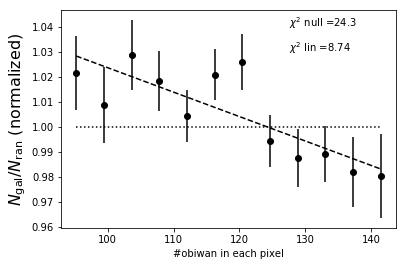

In [212]:
sys_test(hp_obiwan['num_obiwan'],hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'#obiwan in each pixel')

total number of randoms/objects 952006.0/101202.0
number of randoms/objects outside tested range 94867.0/10038.0
average number of objects per random is 0.10630395186584958
30.5442800482
b=1.04749894345 m=-0.613019836071
24.8666232681


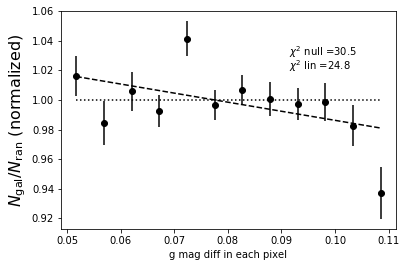

In [231]:
sys_test(hp_obiwan['hist_mag_diff_g']/hp_obiwan['num_obiwan'],\
         hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'g mag diff in each pixel')

total number of randoms/objects 952006.0/101202.0
number of randoms/objects outside tested range 98134.0/10450.0
average number of objects per random is 0.10630395186584958
13.9896348836
b=0.995845879911 m=0.0691829763301
13.8794200049


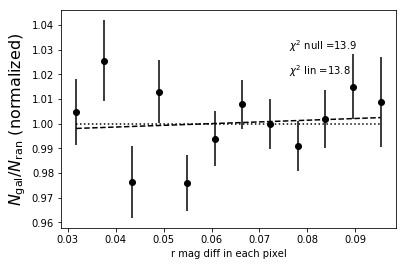

In [230]:
sys_test(hp_obiwan['hist_mag_diff_r']/hp_obiwan['num_obiwan'],\
         hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'r mag diff in each pixel')

total number of randoms/objects 952006.0/101202.0
number of randoms/objects outside tested range 82474.0/9050.0
average number of objects per random is 0.10630395186584958
61.5069149438
b=1.01085963497 m=-0.319624481128
59.5961413566


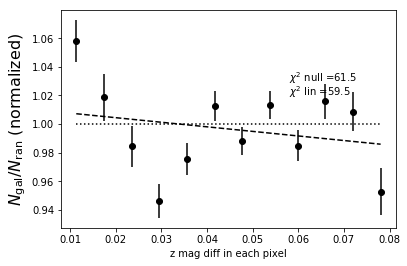

In [229]:
sys_test(hp_obiwan['hist_mag_diff_z']/hp_obiwan['num_obiwan'],\
         hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'z mag diff in each pixel')

total number of randoms/objects 952006.0/101202.0
number of randoms/objects outside tested range 96236.0/10516.0
average number of objects per random is 0.10630395186584958
10.0236629731
b=0.9954045961 m=0.025076739615
9.24829058587


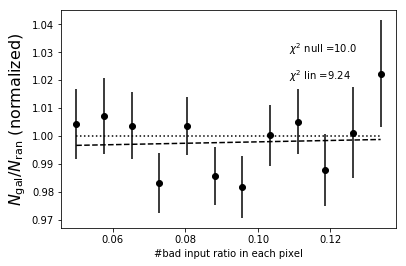

In [228]:
sys_test(hp_obiwan['num_bad']/hp_obiwan['num_obiwan'],hp_obiwan['num_elgs'],\
         hp_obiwan['num_uniform'],'#bad input ratio in each pixel')

total number of randoms/objects 952006.0/101202.0
number of randoms/objects outside tested range 108276.0/11259.0
average number of objects per random is 0.10630395186584958
49.5040966803
b=1.2833519375 m=-0.000592561614233
14.0977942529


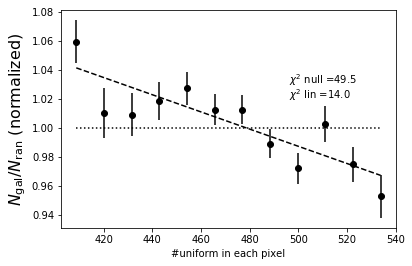

In [226]:
sys_test(hp_obiwan['num_uniform'],hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'#uniform in each pixel')

In [42]:
fn_sim_match = 'sim_match_200per_0125_masked.fits'
sim_match = fits.getdata(topdir + fn_sim_match)
sim_match.columns
#matching sim data with output ELGs

ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'nn_redshift'; format = 'D'
    name = 'sim_in'; format = 'L'
    name = 'sim_true'; format = 'L'
    name = 'VETOMASK'; format = 'B'
    name = 'MCHUNK'; format = 'B'
)

In [54]:
def sim_match_analysis(sim_dat = sim_match):
    import healpy as hp
    res = 128
    sim_true = sim_dat['sim_true']
    sel = (sim_true == True)
    sim_in_elgs = sim_dat[sel]
    pixs = hp.ang2pix(res,sim_in_elgs['ra'],sim_in_elgs['dec'],nest = True, lonlat = True)
    sim_in = sim_dat['sim_in']
    sim_True = sim_dat['sim_true']
    sel = (sim_in==False)&(sim_True==True)
    sim_good_out = sim_dat[sel]
    pixs_good_out = hp.ang2pix(res,sim_good_out['ra'],sim_good_out['dec'],nest = True,lonlat = True)
    N = 12*res**2
    hist_all = np.zeros(N)
    hist_good_out = np.zeros(N)
    for i in range(len(pixs)):
        n_all = pixs[i]
        hist_all[n_all]+=1
    for i in range(len(pixs_good_out)):
        n_good_out = pixs_good_out[i]
        hist_good_out[n_good_out]+=1
    
    N = 12*res**2
    ra,dec = hp.pix2ang(128,np.arange(N), nest = True,lonlat = True)
    col1 = fits.Column(name = 'ra', array = ra, format = 'D')
    col2 = fits.Column(name = 'dec', array = dec, format = 'D')
    col3 = fits.Column(name = 'num_all', array = hist_all, format = 'D')
    col4 = fits.Column(name = 'num_good_out', array = hist_good_out, format = 'D')
    dat = fits.BinTableHDU.from_columns([col1,col2,col3,col4]).data
    nall = dat['num_all']
    sel = (nall>0)
    return dat[sel]
dat = sim_match_analysis()

In [41]:
sim_true = sim_match['sim_in']
sel = (sim_true == False)
sim_in_elgs = sim_match[sel]
len(sim_in_elgs)

0

In [19]:
len(sim_match)

935534

In [20]:
sim_match['sim_true']

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [25]:
sim_match['sim_in']

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [43]:
MCHUNK = sim_match['MCHUNK']
VETOMASK = sim_match['VETOMASK']
sel = (MCHUNK==1)&(VETOMASK==1)
dat2 = sim_match[sel]


In [45]:
sim_true = dat2['sim_in']
sel = (sim_true == False)
sim_in_elgs = dat2[sel]
len(sim_in_elgs)

163235

In [55]:
dddt = sim_match_analysis(sim_dat = dat2)

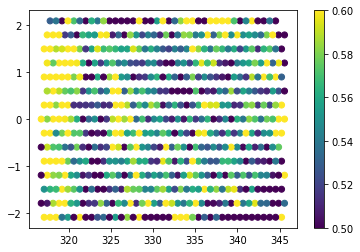

In [63]:
plt.scatter(dddt['ra'],dddt['dec'],c = dddt['num_good_out']/dddt['num_all'],vmin=0.5,vmax=0.6)
plt.colorbar()

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.,    0.,    1.,    1.,    1.,    0.,    1.,    7.,    0.,
           3.,    1.,    2.,    4.,    9.,   24.,   24.,   97.,   84.,
         110.,   89.,   65.,   35.,   25.,    9.,    8.,    6.,    1.,
           2.,    0.,    0.,    3.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    2.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

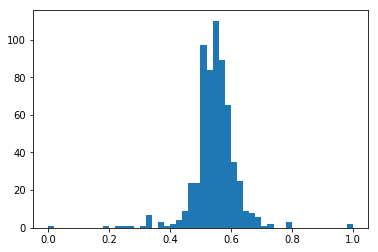

In [61]:
plt.hist(dddt['num_good_out']/dddt['num_all'],bins = 50)

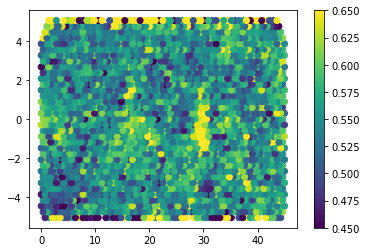

In [66]:
MCHUNK = sim_match['MCHUNK']
VETOMASK = sim_match['VETOMASK']
sel = (MCHUNK==2)&(VETOMASK==1)
dat2 = sim_match[sel]

sim_true = dat2['sim_in']
sel = (sim_true == False)
sim_in_elgs = dat2[sel]
len(sim_in_elgs)

dddt = sim_match_analysis(sim_dat = dat2)

plt.scatter(dddt['ra'],dddt['dec'],c = dddt['num_good_out']/dddt['num_all'],vmin=0.45,vmax=0.65)
plt.colorbar()

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    3.,    0.,    2.,    0.,    5.,    2.,
           1.,    1.,    3.,   11.,   21.,   55.,  120.,  249.,  348.,
         438.,  386.,  272.,  153.,   76.,   27.,   18.,    9.,   10.,
           5.,    7.,    3.,    1.,    5.,    0.,    4.,    2.,    0.,
           0.,    0.,    0.,    0.,    4.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

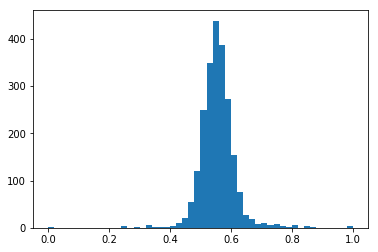

In [65]:
plt.hist(dddt['num_good_out']/dddt['num_all'],bins = 50)

In [4]:
fn = 'elg_match_w_flux.fits'
dat = fits.getdata(topdir+fn)
dat.columns

ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'flux_z'; format = 'E'
    name = 'mw_transmission_z'; format = 'E'
    name = 'z'; format = 'D'
    name = 'flux_g'; format = 'E'
    name = 'mw_transmission_g'; format = 'E'
    name = 'g'; format = 'D'
    name = 'flux_r'; format = 'E'
    name = 'mw_transmission_r'; format = 'E'
    name = 'r'; format = 'D'
    name = 'nn_redshift'; format = 'D'
    name = 'brickname'; format = '8A'
    name = 'angdis'; format = 'D'
    name = 'n'; format = 'D'
    name = 'fracdev'; format = 'E'
    name = 'shapeexp_r'; format = 'E'
    name = 'shapedev_r'; format = 'E'
    name = 'rhalf'; format = 'D'
)

In [74]:
#exp:
fracdev = dat['fracdev']
shapeexp_r = dat['shapeexp_r']
n = dat['n']
rhalf = dat['rhalf']
sel = (fracdev<0.5)&(n==1)
d_exp = dat[sel]


In [53]:
DAT.columns

ColDefs(
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'Z'; format = 'D'
    name = 'WEIGHT_SYSTOT'; format = 'D'
    name = 'WEIGHT_CP'; format = 'D'
    name = 'WEIGHT_NOZ'; format = 'D'
    name = 'NZ'; format = 'D'
    name = 'WEIGHT_FKP'; format = 'D'
    name = 'sector_TSR'; format = 'D'
    name = 'COMP_BOSS'; format = 'D'
    name = 'plate_MJD_SSR'; format = 'D'
    name = 'sector_SSR'; format = 'D'
    name = 'chunk'; format = '7A'
    name = 'plate'; format = 'J'
    name = 'tile'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'sector'; format = 'J'
    name = 'ELG_sector'; format = 'J'
    name = 'sector_area'; format = 'D'
    name = 'sector_ntiles'; format = 'I'
    name = 'sector_tiles'; format = '4I'
    name = 'INGROUP'; format = 'J'
    name = 'ELG_INGROUP'; format = 'J'
    name = 'MULTGROUP'; format = 'J'
    name = 'EBOSS_TARGET1'; format = 'K'
    name = 'BOSSTILE_STATUS'; format = 'J'
    name = 'TRIMMED'; format = 'J'
    name =

In [52]:
fracdev = DAT['fracdev']
shapeexp_r = DAT['shapeexp_r']

rhalf = DAT['rhalf']
sel = (fracdev<0.5)
D_exp = dat[sel]

KeyError: "Key 'fracdev' does not exist."

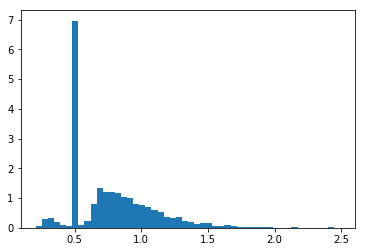

In [26]:
p1 = plt.hist(d_exp['rhalf'],bins = 50,density = True)
#p2 = plt.hist(d_exp['shapeexp_r'],bins = 50,density = True)
#plt.gca().set_ylim((0,2))
#plt.gca().set_xlim((0,3))

[0, 5, 0, 3]

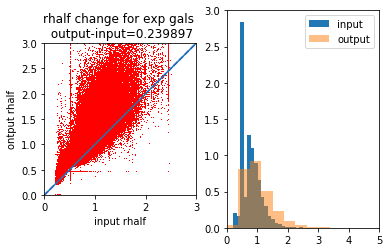

In [76]:
plt.subplot(1,2,1)
plt.plot(d_exp['rhalf'],d_exp['shapeexp_r'],'r,')
plt.gca().set_aspect('equal', 'box')
plt.axis([0, 3, 0, 3])
plt.plot([0, 3], [0, 3],'b--')
plt.xlabel('input rhalf')
plt.ylabel('ontput rhalf')
plt.title('rhalf change for exp gals \n output-input=%f' %(d_exp['shapeexp_r'].mean()-d_exp['rhalf'].mean()))  

plt.plot(d_exp['rhalf'],d_exp['shapeexp_r'],'r,')
plt.gca().set_aspect('equal')
plt.axis([0, 3, 0, 3])
plt.plot([0, 3], [0, 3])
plt.subplot(1,2,2)
plt.hist(d_exp['rhalf'],bins = 20,density = True,label='input')
plt.hist(d_exp['shapeexp_r'],bins = 50,density = True,alpha=0.5,label='output')
plt.legend()
plt.axis([0, 5, 0, 3])

(0, 50)

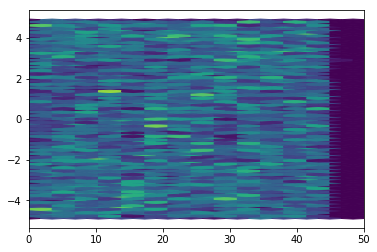

In [84]:
u = d_exp['shapeexp_r']
sss = (u>2)
ttt = d_exp[sss]
plt.hexbin(ttt['ra'],ttt['dec'])
plt.gca().set_xlim((0,50))

(0, 0.5)

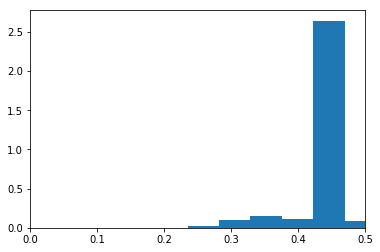

In [37]:
p2 = plt.hist(d_exp['shapeexp_r'],bins = 400,density = True)
plt.gca().set_xlim((0,0.5))

In [68]:
#dev:
fracdev = dat['fracdev']
shapeexp_r = dat['shapeexp_r']
n = dat['n']
rhalf = dat['rhalf']
sel = (fracdev>0.5)&(n==4)
d_exp = dat[sel]

[0, 5, 0, 3]

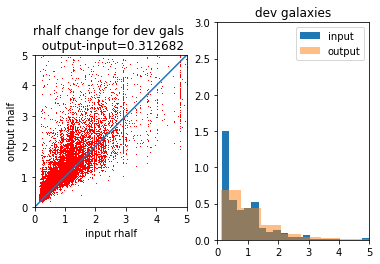

In [72]:
plt.subplot(1,2,1)
plt.plot(d_exp['rhalf'],d_exp['shapedev_r'],'r,')
plt.gca().set_aspect('equal', 'box')
plt.axis([0, 5, 0, 5])
plt.plot([0, 5], [0, 5])
plt.xlabel('input rhalf')
plt.ylabel('ontput rhalf')
plt.title('rhalf change for dev gals \n output-input=%f' %(d_exp['shapedev_r'].mean()-d_exp['rhalf'].mean())) 


plt.subplot(1,2,2)
plt.hist(d_exp['rhalf'],bins = 20,density = True,label='input')
plt.hist(d_exp['shapedev_r'],bins = 50,density = True,alpha=0.5,label='output')
plt.legend()
plt.title('dev galaxies')
plt.axis([0, 5, 0, 3])

In [44]:
d_exp['shapeexp_r']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)